In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import plotly
import os
print(os.getcwd())

/home/savvyfox/Projects/safe-control-gym/examples/rl


In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w) / w, mode='valid')
    
def load_from_log_file(path):
    '''Return x, y sequence data from the stat csv.'''
    with open(path, 'r') as f:
        lines = f.readlines()
    # Labels.
    xk, yk = [k.strip() for k in lines[0].strip().split(',')]
    # Values.
    x, y = [], []
    for line in lines[1:]:
        data = line.strip().split(',')
        x.append(float(data[0].strip()))
        y.append(float(data[1].strip()))
    x = np.array(x)
    y = np.array(y)
    return xk, x, yk, y

In [3]:
seeds = [i for i in range(0,10)]
#seeds = [0]

data_paths = {
             "PPO": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Longest_run/",
             # "ppo_1": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Long_run/", 
             # "ppo_2": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Medium_run/",
             # "ppo_22": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Medium_run2/",
             # "ppo_3": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Short_run/",
             # "ppo_4": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Shortest_run/",
             "SAC": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Longest_run/",
             # "sac_1": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Long_run/", 
             # "sac_2": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Medium_run/",
             # "sac_22": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Medium_run2/",
             # "sac_3": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Short_run/",
             # "sac_4": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Shortest_run/",
}

colors = {
    "PPO": "orange",
    "SAC": "green",
    "GP MPC": "royalblue",
    "iLQR": "gray"
}

In [4]:
perf_data = {}
for method in data_paths.keys():
    print(method)
    perf_data.update({method: {}})
    for seed in seeds:
        xk, x, lk, l = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_length.log")
        xk, x, yk, y = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return.log")
        xk, x, zk, z = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return_std.log")
        # xk, x, ck, c = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/constraint_violation.log")
        # perf_data[method].update({seed: {"x": x, "y": y, "c": c}})
        # perf_data[method].update({seed: {"x": x, "y": y, "z": z, "c": c}})
        xk, x, yk, m = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/mse.log")
        xk, x, yk, n = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/mse_std.log")
        # perf_data[method].update({"x": x, "y": y, "z": z, "x1": x1, "y1": y1, "z1": z1})
        perf_data[method].update({seed: {"x": x, "y": y, "z": z, "m": m, "n": n, "l": l}})

PPO
SAC


PPO
SAC


Text(0.5, 1.0, 'Task: Quadrotor 2D')

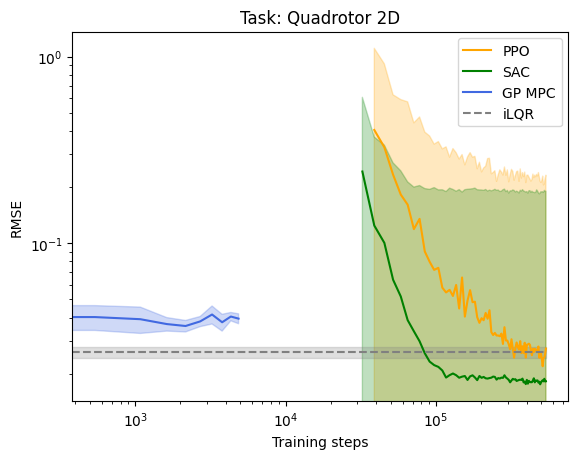

In [8]:
eval_data = {}
w = 1
fig = plt.figure()
last_iter = perf_data["PPO"][0]["x"][-1]
for method in data_paths.keys():
    print(method)
    temp = np.zeros((len(seeds), 6, perf_data[method][seeds[0]]["x"].shape[0]))
    for seed in seeds:
        # print(seed)
        temp[seed, 0, :] = perf_data[method][seed]["x"]
        temp[seed, 1, :] = perf_data[method][seed]["y"]
        temp[seed, 2, :] = perf_data[method][seed]["z"]
        temp[seed, 3, :] = (perf_data[method][seed]["m"])**0.5
        temp[seed, 4, :] = perf_data[method][seed]["n"]**0.5
        temp[seed, 5, :] = perf_data[method][seed]["l"]
    for seed in seeds:
        for j,k in enumerate(temp[seed, 0, :]):
            if temp[seed, 5, j] < 540:
                temp[seed, 0, j] = np.nan
                temp[seed, 1, j] = np.nan
                temp[seed, 2, j] = np.nan
                temp[seed, 3, j] = np.nan
                temp[seed, 4, j] = np.nan
    eval_data.update({method: temp})
    start_iter = last_iter - perf_data[method][seed]["x"][-1]

    # plotting performance
    # plt.plot(start_iter+temp[0,0,w-1:], moving_average(np.mean(temp[:,3,:], axis=0), w), label=method)
    # plt.fill_between(start_iter+temp[0,0,w-1:], 
    #                  moving_average(np.mean(temp[:,3,:], axis=0)-np.mean(temp[:,4,:], axis=0), w), 
    #                  moving_average(np.mean(temp[:,3,:], axis=0)+np.mean(temp[:,4,:], axis=0), w), alpha=0.25)
    plt.plot(start_iter+temp[0,0,:], np.mean(temp[:,3,:], axis=0), color=colors[method], label=method)
    plt.fill_between(start_iter+temp[0,0,:], 
                     np.mean(temp[:,3,:], axis=0)-np.mean(temp[:,4,:], axis=0),  
                     np.mean(temp[:,3,:], axis=0)+np.mean(temp[:,4,:], axis=0), color=colors[method], alpha=0.25)

    # plotting constraint violations
    # plt.plot(temp[0,0,:], np.mean(temp[:,3,:], axis=0), label=method)

gp_mpc_data = np.load("./Results/LSY_pc/GPMPC_rmse_200_mass_20_sample_10_epoch.npy", allow_pickle=True).item()
start_iter = last_iter - gp_mpc_data['train_steps'][-1]
plt.plot(0*start_iter+gp_mpc_data['train_steps'], gp_mpc_data['mean'], color=colors["GP MPC"], label='GP MPC')
plt.fill_between(0*start_iter+gp_mpc_data['train_steps'], 
                 gp_mpc_data['mean']-gp_mpc_data['std'], 
                 gp_mpc_data['mean']+gp_mpc_data['std'], color=colors["GP MPC"], alpha=0.25)

s = 1 # time std
rmse_ilqr_mean = 0.026000000000000002
rmse_ilqr_std = 0.001843908891458577
plt.axhline(xmin=0.0, xmax=0.95, y=rmse_ilqr_mean, linestyle='--', color=colors["iLQR"], label='iLQR')
plt.fill_between([0.0, last_iter], rmse_ilqr_mean-s*rmse_ilqr_std, rmse_ilqr_mean+s*rmse_ilqr_std, color=colors["iLQR"], alpha=0.25)

# gp_05 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_0.5_cost.npy", allow_pickle=True)
# gp_10 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_1.0_cost.npy", allow_pickle=True)
# gp_30 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_3.0_cost.npy", allow_pickle=True)
# plt.plot(gp_05.item()["mean"][:,0], gp_05.item()["mean"][:,1], label="GP-MPC (m=0.5)")
# plt.fill_between(gp_05.item()["mean"][:,0], gp_05.item()["mean"][:,1]-gp_05.item()["std"], gp_05.item()["mean"][:,1]+gp_05.item()["std"], alpha=0.25)
# plt.plot(gp_10.item()["mean"][:,0], gp_10.item()["mean"][:,1], label="GP-MPC (m=1.0)")
# plt.fill_between(gp_10.item()["mean"][:,0], gp_10.item()["mean"][:,1]-gp_10.item()["std"], gp_10.item()["mean"][:,1]+gp_10.item()["std"], alpha=0.25)
# plt.plot(gp_30.item()["mean"][:,0], gp_30.item()["mean"][:,1], label="GP-MPC (m=3.0)")
# plt.fill_between(gp_30.item()["mean"][:,0], gp_30.item()["mean"][:,1]-gp_30.item()["std"], gp_30.item()["mean"][:,1]+gp_30.item()["std"], alpha=0.25)
# gp_05 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_0.5_constraint_percentage.npy", allow_pickle=True)
# gp_10 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_1.0_constraint_percentage.npy", allow_pickle=True)
# gp_30 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_3.0_constraint_percentage.npy", allow_pickle=True)
# plt.plot(gp_05.item()["mean"][:,0], gp_05.item()["mean"][:,1], label="GP-MPC (m=0.5)")
# plt.plot(gp_10.item()["mean"][:,0], gp_10.item()["mean"][:,1], label="GP-MPC (m=1.0)")
# plt.plot(gp_30.item()["mean"][:,0], gp_30.item()["mean"][:,1], label="GP-MPC (m=3.0)")


plt.legend()
# plt.ylim(-200,00)
plt.xscale("log")
# plt.gca().invert_xaxis()
plt.yscale("log")
plt.xlabel("Training steps")
plt.ylabel("RMSE")
plt.title("Task: Quadrotor 2D")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)

In [15]:
np.mean(temp[:,3,:], axis=0),np.mean(temp[:,4,:], axis=0)

(array([ 5.56661044,  8.98567327,  6.40123258, 14.21983029, 13.08274237,
         8.77096302,  8.71078224,  5.30294769,  4.94162143,  3.66671972,
         3.31768475,  2.55528452,  2.02426006,  2.07484464,  1.40722345,
         1.84371323]),
 array([ 5.56661044,  8.98567327,  6.40123258, 14.21983029, 13.08274237,
         8.77096302,  8.71078224,  5.30294769,  4.94162143,  3.66671972,
         3.31768475,  2.55528452,  2.02426006,  2.07484464,  1.40722345,
         1.84371323]))

In [ ]:
eval_data = {}
fig = plt.figure()
for method in data_paths.keys():
    temp = np.zeros((len(seeds), 4, perf_data[method][seeds[0]]["x"].shape[0]))
    for seed in seeds:
        temp[seed, 0, :] = perf_data[method][seed]["x"]
        temp[seed, 1, :] = perf_data[method][seed]["y"]
        # temp[seed, 2, :] = perf_data[method][seed]["z"]
        temp[seed, 3, :] = perf_data[method][seed]["c"]
    eval_data.update({method: temp})

    # plotting
    plt.plot(temp[0,0,:], np.mean(temp[:,3,:], axis=0), label=method)
    # plt.fill_between(temp[0,0,:], np.mean(temp[:,1,:], axis=0)+np.mean(temp[:,2,:], axis=0)**.5, np.mean(temp[:,1,:], axis=0)-np.mean(temp[:,2,:], axis=0)**0.5, alpha=0.25)
plt.legend()
# plt.ylim(0,10)
plt.xscale("log")
plt.xlabel("Training steps")
plt.ylabel("% Constraint violation")
plt.title("Task: Cartpole")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)

In [ ]:
gp_05 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_0.5_constraint_percentage.npy", allow_pickle=True)
gp_10 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_1.0_constraint_percentage.npy", allow_pickle=True)
gp_30 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_3.0_constraint_percentage.npy", allow_pickle=True)

gp_30.item()

In [ ]:
# data_paths = {"ppo_pyb": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/0", 
#              "ppo_sysid": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/1"}
data_paths = {"ppo_1": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Long_run", 
             "ppo_2": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Medium_run",
             "ppo_3": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Short_run",
             "sac_1": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Long_run", 
             "sac_2": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Medium_run",
             "sac_3": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Short_run",}

In [ ]:
perf_data = {}
for method in data_paths.keys():
    print(method)
    if method != "ppo_4":
        perf_data.update({method: {}})
        xk, x, yk, y = load_from_log_file(data_paths[method] + "/logs/stat_eval/ep_return.log")
        xk, x, zk, z = load_from_log_file(data_paths[method] + "/logs/stat_eval/ep_return_std.log")
        # xk, x1, yk, y1 = load_from_log_file(data_paths[method] + "/HW/" + "/logs/stat_eval/ep_return.log")
        # xk, x1, zk, z1 = load_from_log_file(data_paths[method] + "/HW/" + "/logs/stat_eval/ep_return_std.log")
        xk, x, yk, m = load_from_log_file(data_paths[method] + "/logs/stat_eval/mse.log")
        # perf_data[method].update({"x": x, "y": y, "z": z, "x1": x1, "y1": y1, "z1": z1})
        perf_data[method].update({"x": x, "y": y, "z": z, "m": m})
    else:
        perf_data.update({method: {}})
        xk, x, yk, y = load_from_log_file(data_paths[method] + "/logs/stat_eval/ep_return.log")
        xk, x, zk, z = load_from_log_file(data_paths[method] + "/logs/stat_eval/ep_return_std.log")
        perf_data[method].update({"x": x, "y": y, "z": z})

In [ ]:
perf_data

In [ ]:
fig = plt.figure()
method = "ppo_1"
plt.plot(perf_data[method]["x"], perf_data[method]["y"], 'r', label=method)
# plt.fill_between(perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
#                      perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
last_iter1 = perf_data[method]["x"][-1]
last_iter = last_iter1
plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")
plt.plot(last_iter+perf_data[method]["x1"], perf_data[method]["y1"], 'r')
# plt.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
#                      perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)


method = "ppo_2"
start_iter = last_iter1 - perf_data[method]["x"][-1]
plt.plot(start_iter+perf_data[method]["x"], perf_data[method]["y"], 'g', label=method)
# plt.fill_between(start_iter+perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
#                      perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")
plt.plot(last_iter+perf_data[method]["x1"], perf_data[method]["y1"], 'g')
# plt.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
#                      perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)


method = "ppo_3"
start_iter = last_iter1 - perf_data[method]["x"][-1]
plt.plot(start_iter+perf_data[method]["x"], perf_data[method]["y"], 'b', label=method)
# plt.fill_between(start_iter+perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
#                      perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
# last_iter = perf_data[method]["x"][-1]
plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")
plt.plot(last_iter+perf_data[method]["x1"], perf_data[method]["y1"], 'b')
# plt.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
#                      perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)

method = "ppo_4"
# start_iter = last_iter1 - perf_data[method]["x"][-1]
# plt.plot(start_iter+perf_data[method]["x"], perf_data[method]["y"], 'b', label=method)
# plt.fill_between(start_iter+perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
#                      perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
# last_iter = perf_data[method]["x"][-1]
# plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")
plt.plot(last_iter+perf_data[method]["x"], perf_data[method]["y"], 'm', label=method)
# plt.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
#                      perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)

plt.legend()
plt.ylim(00, 600)
plt.xscale("log")
plt.xlabel("Training steps")
plt.ylabel("Cummulative return")
plt.title("Task: Quad_2d")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)

In [ ]:
ax1 = plt.subplot(3,1,1)
method = "ppo_1"
ax1.plot(perf_data[method]["x"], perf_data[method]["y"], 'b', label=method)
ax1.fill_between(perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
                     perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
# last_iter = perf_data[method]["x"][-1]
# plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")

method = "ppo_2"
ax1.plot(perf_data[method]["x"], perf_data[method]["y"], label=method)
ax1.fill_between(perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
                     perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
# last_iter = perf_data[method]["x"][-1]
# ax1.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")

method = "ppo_3"
ax1.plot(perf_data[method]["x"], perf_data[method]["y"], label=method)
ax1.fill_between(perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
                     perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
# last_iter = perf_data[method]["x"][-1]
# plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")

ax2 = plt.subplot(3,3,1)
method = "ppo_1"
ax2.plot(perf_data[method]["x1"], perf_data[method]["y1"], 'b')
ax2.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
                     perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)
method = "ppo_2"
ax2.plot(perf_data[method]["x1"], perf_data[method]["y1"], label=method)
ax2.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
                     perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)
method = "ppo_3"
ax2.plot(perf_data[method]["x1"], perf_data[method]["y1"], label=method)
ax2.fill_between(perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
                     perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)
method = "ppo_4"
ax2.plot(perf_data[method]["x"], perf_data[method]["y"], label=method)
ax2.fill_between(perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
                     perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)

plt.legend()
plt.ylim(00, 600)
# plt.xscale("log")
plt.xlabel("Training steps")
plt.ylabel("Cummulative return")
plt.title("Task: Quad_2d")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)